In [1]:

from meld_classifier.paths import BASE_PATH, EXPERIMENT_PATH,MELD_DATA_PATH, NEWSUBJECTS_DATASET
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import pandas as pd
import neuroCombat as nc
import meld_classifier.distributedCombat as dc
import numpy as np
import neuroCombat as nc
from meld_classifier.data_preprocessing import Preprocess
# from pygam import LinearGAM,s
%matplotlib inline

Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/test_meld
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/test_meld/output/preprocessed_surf_data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/test_meld/models
Setting FS_SUBJECTS_PATH to /rds/project/kw350/rds-kw350-meld/test_meld/output/fs_outputs


In [1]:
new_site_code = 'H29'
feature = '.on_lh.thickness.sm10.mgh'
import meld_classifier.paths as p
site_combat_path = os.path.join(BASE_PATH,'distributed_combat')
if not os.path.isdir(site_combat_path):
    os.makedirs(site_combat_path)


Setting MELD_DATA_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments_graph/co-ripa1
Setting FS_SUBJECTS_PATH to 


NameError: name 'os' is not defined

In [3]:
listids

['MELD_H29_3T_FCD_0042',
 'MELD_H29_3T_FCD_0051',
 'MELD_H29_3T_FCD_0052',
 'MELD_H29_3T_FCD_0053',
 'MELD_H29_3T_FCD_0054',
 'MELD_H29_3T_FCD_0055',
 'MELD_H29_3T_FCD_0056',
 'MELD_H29_3T_FCD_0057',
 'MELD_H29_3T_FCD_0058',
 'MELD_H29_3T_FCD_0059',
 'MELD_H29_3T_FCD_0060',
 'MELD_H29_3T_FCD_0061',
 'MELD_H29_3T_FCD_0062',
 'MELD_H29_3T_FCD_0063',
 'MELD_H29_3T_FCD_00632',
 'MELD_H29_3T_FCD_0064',
 'MELD_H29_3T_FCD_0065',
 'MELD_H29_3T_FCD_0067',
 'MELD_H29_3T_FCD_0068',
 'MELD_H29_3T_FCD_0069',
 'MELD_H29_3T_FCD_0070',
 'MELD_H29_3T_FCD_0071',
 'MELD_H29_3T_FCD_0072',
 'MELD_H29_3T_FCD_0073',
 'MELD_H29_3T_FCD_0074',
 'MELD_H29_3T_FCD_0075',
 'MELD_H29_3T_FCD_0076',
 'MELD_H29_3T_FCD_0077',
 'MELD_H29_3T_FCD_0078',
 'MELD_H29_3T_FCD_0079',
 'MELD_H29_3T_FCD_0080',
 'MELD_H29_3T_FCD_0081',
 'MELD_H29_3T_FCD_0083',
 'MELD_H29_3T_FCD_0086']

In [24]:
c_combat =  MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5', dataset=None,
                      data_dir=MELD_DATA_PATH)
listids = c_combat.get_subject_ids(site_codes=site_codes, lesional_only=True)

preprocessor=Preprocess(c_combat)
#load in precombat data
ref_subject_ids = c_combat.get_subject_ids(lesional_only=False)
new_site_codes=np.zeros(len(ref_subject_ids))
precombat_features=[]
combat_subject_include = np.zeros(len(ref_subject_ids), dtype=bool)

for k, subject in enumerate(ref_subject_ids):
    # get the reference index and cohort object for the site, 0 whole cohort, 1 new cohort
    site_code_index = new_site_codes[k]
    
    subj = MeldSubject(subject, cohort=c_combat)
    # exclude outliers and subject without feature
    if (subj.has_features(f'.combat{feature}')) :
        lh = subj.load_feature_values(f'.combat{feature}', hemi="lh")[c_combat.cortex_mask]
        rh = subj.load_feature_values(f'.combat{feature}', hemi="rh")[c_combat.cortex_mask]
        combined_hemis = np.hstack([lh, rh])
        precombat_features.append(combined_hemis)
        combat_subject_include[k] = True
    else:
        combat_subject_include[k] = False

#calculate distributed combat parameters for central site
precombat_features = np.array(precombat_features).T


In [25]:
covars = preprocessor.load_covars(ref_subject_ids)

covars = covars[combat_subject_include].copy()
covars = covars.reset_index()
N=len(covars)
bat = pd.Series(pd.Categorical(np.repeat('H0', N), categories=['H0', new_site_code]))

covars['site_scanner']=bat
covars = covars[['ages','sex','group','site_scanner']]


/home/kw350/software/main_meld/meld_classifier/meld_classifier/data_preprocessing.py:129: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  covars["ages"] = covars.groupby("site_scanner").transform(lambda x: x.fillna(x.mean()))["ages"]


In [26]:
#use var estimates from basic combat
com_out = nc.neuroCombat(precombat_features, covars, 'site_scanner')
with open(os.path.join(site_combat_path,f'MELD_{feature}_var.pickle'), "wb") as f:
    pickle.dump(com_out['estimates']['var.pooled'], f)
#calculate reference estimates for distributed combat
_ = dc.distributedCombat_site(precombat_features, bat, covars[['ages','sex','group']], 
                          file=os.path.join(site_combat_path,f'MELD_{feature}.pickle'), ref_batch = 'H0')


[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments


/home/kw350/software/main_meld/neuroCombat/neuroCombat/neuroCombat.py:324: RuntimeWarning: divide by zero encountered in true_divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


[neuroCombat] Final adjustment of data


In [2]:
###new site stuff starts here

new_site_code = 'H29'
feature = '.on_lh.thickness.sm10.mgh'
import meld_classifier.paths as p
site_combat_path = os.path.join(BASE_PATH,'distributed_combat')
if not os.path.isdir(site_combat_path):
    os.makedirs(site_combat_path)

In [3]:
new_sites=['H29']
c_raw = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_smoothed_NewSite.hdf5', 
                   dataset='MELD_dataset_NewSiteH29.csv',
                  data_dir=MELD_DATA_PATH)
listids = c_raw.get_subject_ids(site_codes=new_sites, lesional_only=False)

DEMOGRAPHIC_FEATURES_FILE = "demographics_qc_allgroups_with_H29.csv"
new_site_codes = np.zeros(len(listids))
precombat_features=[]
combat_subject_include = np.zeros(len(listids), dtype=bool)
demos=[]
for k, subject in enumerate(listids):
    # get the reference index and cohort object for the site, 0 whole cohort, 1 new cohort
    site_code_index = new_site_codes[k]
    
    subj = MeldSubject(subject, cohort=c_raw)
    demo = subj.get_demographic_features(['Age at preop','Sex','group',],
                                         csv_file = DEMOGRAPHIC_FEATURES_FILE)
    demo[2]=demo[2]=='patient'
    demos.append(demo)
    # exclude outliers and subject without feature
    if (subj.has_features(feature)) :
        lh = subj.load_feature_values(feature, hemi="lh")[c_raw.cortex_mask]
        rh = subj.load_feature_values(feature, hemi="rh")[c_raw.cortex_mask]
        combined_hemis = np.hstack([lh, rh])
        precombat_features.append(combined_hemis)
        combat_subject_include[k] = True
    else:
        combat_subject_include[k] = False

#calculate distributed combat parameters for central site
new_site_data = np.array(precombat_features).T
demos = np.array(demos).astype(np.float64)
demos = demos[combat_subject_include]

new_site_covars = pd.DataFrame(demos,columns=['ages','sex','group'])
N=len(new_site_covars)
bat = pd.Series(pd.Categorical(np.repeat(new_site_code, N),
                               categories=['H0', new_site_code]))


new_site_covars['site_scanner']=bat
new_site_covars = new_site_covars[['ages','sex','group','site_scanner']]


In [5]:
print('step1')
dc.distributedCombat_site(new_site_data,
                          bat, 
                          new_site_covars[['ages','sex','group']], 
                          file=os.path.join(site_combat_path,f"{new_site_code}_{feature}_summary.pickle"), 
                      ref_batch = 'H0')
print('step2')

dc_out = dc.distributedCombat_central(
    [os.path.join(site_combat_path,f'MELD_{feature}.pickle'),
     os.path.join(site_combat_path,f"{new_site_code}_{feature}_summary.pickle")], ref_batch = 'H0'
)
# third, use variance estimates from full MELD cohort

dc_out['var_pooled'] = pd.read_pickle(os.path.join(site_combat_path,f'MELD_{feature}_var.pickle')).ravel()
for c in ['ages','sex','group']:
    new_site_covars[c]=new_site_covars[c].astype(np.float64)
print('step3')

_=dc.distributedCombat_site(
    pd.DataFrame(new_site_data), bat, new_site_covars[['ages','sex','group']], 
    file=os.path.join(site_combat_path,f"{new_site_code}_{feature}_harmonisation_params.pickle"),
     central_out=dc_out, 
    ref_batch = 'H0'
)

step1
step2
Must specify filename to output results as a file. Currently saving output to current workspace only.
step3


/rds/user/co-ripa1/hpc-work/scripts/meld_classifier/meld_classifier/distributedCombat_helpers.py:229: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  np.linalg.inv(np.matmul(batch_design.transpose(), batch_design)),
/rds/user/co-ripa1/hpc-work/scripts/meld_classifier/meld_classifier/distributedCombat_helpers.py:232: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the 

Traceback (most recent call last):
  File "/home/co-ripa1/.conda/envs/meld_classifier/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_60038/3406932728.py", line 24, in <module>
    ref_batch = 'H0'
  File "/rds/user/co-ripa1/hpc-work/scripts/meld_classifier/meld_classifier/distributedCombat.py", line 175, in distributedCombat_site
    eb=eb,
  File "/rds/user/co-ripa1/hpc-work/scripts/meld_classifier/meld_classifier/distributedCombat_helpers.py", line 376, in getCorrectedData
    + mod_mean
  File "<__array_function__ internals>", line 6, in einsum
  File "/home/co-ripa1/.conda/envs/meld_classifier/lib/python3.7/site-packages/numpy/core/einsumfunc.py", line 1350, in einsum
    return c_einsum(*operands, **kwargs)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/co-ripa1/.conda/envs/meld

TypeError: object of type 'NoneType' has no len()

In [2]:
### test preprocess function 
new_site_code = 'H29'
feature='.on_lh.pial.K_filtered.sm20.mgh'
site_combat_path = os.path.join(BASE_PATH,'distributed_combat')
dataset_newSite='MELD_dataset_NewSiteH29.csv'
demographic_file_newSite=os.path.join(BASE_PATH,"demographics_qc_allgroups_with_H29.csv")

#create cohort for the new subject
c_smooth= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_smoothed_NewSite.hdf5', 
                   dataset=dataset_newSite)
#create object combat
combat =Preprocess(c_smooth,
                       site_codes=[new_site_code],
                       write_hdf5_file_root="{site_code}_combat_parameters_NewSite_test.hdf5",
                       data_dir=site_combat_path)
#features names
print(feature)
results = combat.get_combat_new_site_parameters(feature, demographic_file_newSite)

.on_lh.pial.K_filtered.sm20.mgh


/rds/user/co-ripa1/hpc-work/scripts/meld_classifier/meld_classifier/data_preprocessing.py:133: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  covars["ages"] = covars.groupby("site_scanner").transform(lambda x: x.fillna(x.mean()))["ages"]


step1
step2
Must specify filename to output results as a file. Currently saving output to current workspace only.
step3


/rds/user/co-ripa1/hpc-work/scripts/meld_classifier/meld_classifier/distributedCombat_helpers.py:229: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  np.linalg.inv(np.matmul(batch_design.transpose(), batch_design)),
/rds/user/co-ripa1/hpc-work/scripts/meld_classifier/meld_classifier/distributedCombat_helpers.py:232: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the 

In [3]:
results

({'gamma_hat': array([[-0.78173354,  0.35119089,  0.67126478, ..., -0.50376112,
          -0.44727912, -0.41401035]]),
  'delta_hat': array([0.09322168, 2.3790703 , 1.24145214, ..., 0.44573963, 0.48222412,
         0.50503493]),
  'gamma_bar': array([43.72018841]),
  't2': array([1.23971367e+08]),
  'a_prior': array([5.26505806e+09]),
  'b_prior': array([5.26505806e+09]),
  'batches': array(['H29_3T'], dtype=object),
  'delta.star': array([[1.        , 1.00000001, 1.        , ..., 1.        , 1.        ,
          1.        ]]),
  'var.pooled': array([[0.03870954],
         [0.02075465],
         [0.02730621],
         ...,
         [0.03880112],
         [0.03845891],
         [0.03741688]]),
  'gamma.star': array([[-0.78173353,  0.35119089,  0.67126479, ..., -0.50376111,
          -0.44727911, -0.41401035]]),
  'stand.mean': array([0.26105579, 0.24084248, 0.457445  , ..., 0.44218849, 0.45592041,
         0.46873893]),
  'num_subjects': array([46])},
 {'gamma_hat': array([[-0.78173354

In [10]:
estimates=results
target_dict = {'batch':'batches', 'delta_star':'delta.star', 'var_pooled':'var.pooled',
           'gamma_star':'gamma.star', 'stand_mean':'stand.mean', 'mod_mean': 'mod.mean', 
           'parametric': 'del', 'eb':'del', 'mean_only':'del', 'mod':'del', 'ref_batch':'del', 'beta_hat':'del', 
          }
for key in target_dict.keys():  
    if target_dict[key]=='del':
        estimates.pop(key)
    else:
        estimates[target_dict[key]] = estimates.pop(key)
for key in estimates.keys():
    if key in ['a_prior', 'b_prior', 't2', 'gamma_bar']:
        estimates[key]=[estimates[key]]
#     if key == 'batches':
#                 estimates[key]=[str(site_scanner)]
#         print(type(estimates[key]))
#     estimates[key] = np.array(estimates[key])

In [2]:
#test on 1 subject
print('PROCESS 2 : COMBAT')
feature='.on_lh.thickness.sm10.mgh'
dataset_newSubject='MELD_dataset_newSubjects.csv'
#create cohort for the new subject
c_smooth = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_smoothed.hdf5', dataset=dataset_newSubject)
#get combat parameters
combat_params_file = '/rds/project/kw350/rds-kw350-meld/test_meld/output/preprocessed_surf_data/Combat_parameters.hdf5'
#create object combat
combat =Preprocess(c_smooth,
                   write_hdf5_file_root='{site_code}_{group}_featurematrix_combat.hdf5',
                       data_dir=BASE_PATH)
precombat_features, site_scanner, combat_estimates = combat.combat_new_subject(feature, combat_params_file)

PROCESS 2 : COMBAT


OSError: Unable to open file (unable to open file: name = '/rds/project/kw350/rds-kw350-meld/test_meld/output/preprocessed_surf_data/Combat_parameters.hdf5', errno = 2, error message = 'No such file or directory', flags = 1, o_flags = 2)

In [19]:
# pickle_file = '/rds/project/kw350/rds-kw350-meld/meld_data/Data/distributed_combat/H29_.on_lh.thickness.sm10.mgh_harmonisation_params_test.pickle'
# with open(pickle_file, 'rb') as f:
#             params = pickle.load(f)

In [22]:
import h5py
hdf5_file= '/rds/project/kw350/rds-kw350-meld/meld_data/Data/Combat_parameters_6_shrink_with_H29.hdf5'
r=    h5py.File(hdf5_file, "r+")
hdf5_file= '/rds/project/kw350/rds-kw350-meld/test_meld/output/preprocessed_surf_data/MELD_H29/H29_combat_parameters.hdf5'
h29=    h5py.File(hdf5_file, "r+")

In [23]:
feature = '.on_lh.pial.K_filtered.sm20.mgh'
for i,s in enumerate(r[feature]['batches'].attrs["values"].astype(np.str)):
    print(i,s,np.corrcoef(h29[feature]['delta.star'],
           r[feature]['delta.star'][i])[0,1],
      np.corrcoef(h29[feature]['gamma.star'],
           r[feature]['gamma.star'][i])[0,1],
     )

0 H10_3T 0.03611047067703248 -0.1524973743580172
1 H11_3T 0.03056593614806758 0.23517858114472256
2 H12_15T -0.01834228131236281 -0.07650995052819524
3 H12_3T -0.047315266076029865 -0.5593545693546784
4 H14_3T -0.05473414207854472 -0.24032272569551053
5 H15_3T 0.14016740614774917 -0.021286871552831394
6 H16_3T -0.022563227109286228 -0.3726250307039229
7 H17_15T -0.002368860863732969 -0.2847093971605603
8 H17_3T -0.04224952490534496 -0.4409777580739001
9 H18_3T 0.0778671266841565 0.38574330833816506
10 H19_3T -0.038135549532243046 -0.3140146027886635
11 H21_15T 0.046206767744698334 0.5589761312972755
12 H21_3T 0.0398686190457945 0.5257446497170611
13 H23_15T -0.012102492979208887 0.0953331635767892
14 H24_3T 0.012133832603960944 0.2267888797179205
15 H26_15T -0.02592632958718943 -0.2447256877985441
16 H26_3T -0.012974988211320418 0.045198175788307066
17 H29_3T 0.13349614511307786 0.9613531574616873
18 H2_15T -0.02600295361853518 0.2839946013697326
19 H2_3T 0.06326425846523556 -0.2028211

In [73]:
h29[feature].keys()

<KeysViewHDF5 ['a_prior', 'b_prior', 'batches', 'delta.star', 'delta_hat', 'gamma.star', 'gamma_bar', 'gamma_hat', 'num_subjects', 'stand.mean', 't2', 'var.pooled']>

In [24]:
# check correlation combat parameters

features = [
".on_lh.thickness.sm10.mgh",
".on_lh.w-g.pct.sm10.mgh",
".on_lh.pial.K_filtered.sm20.mgh",
'.on_lh.sulc.sm5.mgh',
'.on_lh.curv.sm5.mgh',
'.on_lh.gm_FLAIR_0.25.sm10.mgh',
'.on_lh.gm_FLAIR_0.5.sm10.mgh',
'.on_lh.gm_FLAIR_0.75.sm10.mgh',
".on_lh.gm_FLAIR_0.sm10.mgh",
'.on_lh.wm_FLAIR_0.5.sm10.mgh',
'.on_lh.wm_FLAIR_1.sm10.mgh',
] 
a=[]
b=[]
c=[]
d=[]
e=[]
f=[]
for feature in features: 
    i = np.where(r[feature]['batches'].attrs["values"].astype(np.str) =='H29_3T')[0]
    a.append(np.corrcoef(h29[feature]['delta.star'][:],r[feature]['delta.star'][i][:])[0,1])
    b.append(np.corrcoef(h29[feature]['delta_hat'][:],r[feature]['delta_hat'][i][:])[0,1])
    c.append(np.corrcoef(h29[feature]['gamma.star'][:],r[feature]['gamma.star'][i][:])[0,1])
    d.append(np.corrcoef(h29[feature]['gamma_hat'][:],r[feature]['gamma_hat'][i][:])[0,1])
    e.append(np.corrcoef(h29[feature]['stand.mean'],r[feature]['stand.mean'])[0,1])
    f.append(np.corrcoef(h29[feature]['var.pooled'][:].T,r[feature]['var.pooled'][:].T)[0,1])
df= pd.DataFrame(np.array([a,b,c,d,e,f]).T, columns= ['delta.star','delta_hat', 'gamma.star','gamma_hat','stand.mean','var.pooled'], index=features)     
df

,delta.star,delta_hat,gamma.star,gamma_hat,stand.mean,var.pooled
.on_lh.thickness.sm10.mgh,0.948278,0.948289,0.996371,0.996251,0.996583,0.990027
.on_lh.w-g.pct.sm10.mgh,0.950831,0.950231,0.993783,0.993921,0.990506,0.976459
.on_lh.pial.K_filtered.sm20.mgh,0.133496,0.135150,0.961353,0.955556,0.992225,0.774791
.on_lh.sulc.sm5.mgh,0.551702,0.555325,0.901762,0.855053,0.999529,0.571397
.on_lh.curv.sm5.mgh,0.979907,0.979940,0.990341,0.990099,0.998500,0.545937
.on_lh.gm_FLAIR_0.25.sm10.mgh,0.958074,0.958287,0.986581,0.987006,0.984439,0.945660
.on_lh.gm_FLAIR_0.5.sm10.mgh,0.950223,0.950241,0.981216,0.981638,0.984623,0.923614
.on_lh.gm_FLAIR_0.75.sm10.mgh,0.949685,0.949527,0.979532,0.980078,0.982072,0.917832
.on_lh.gm_FLAIR_0.sm10.mgh,0.973491,0.973497,0.992041,0.992237,0.978506,0.972396
.on_lh.wm_FLAIR_0.5.sm10.mgh,0.982981,0.983044,0.995480,0.995496,0.975734,0.751953


In [ ]:
c =  MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat.hdf5', dataset='MELD_dataset_test_distributed.csv')
vals=np.zeros(len(c.cortex_mask))
feature=".on_lh.pial.K_filtered.sm20.mgh"
i = np.where(r[feature]['batches'].attrs["values"].astype(np.str) =='H29_3T')[0][0]
vals_r[c.cortex_mask]=r[feature]['gamma_hat'][i][:][c.cortex_mask.sum()::]
vals_h29[c.cortex_mask]=h29[feature]['gamma_hat'][0][:][c.cortex_mask.sum()::]

In [2]:
import h5py
hdf5_file= '/rds/project/kw350/rds-kw350-meld/meld_data/Data/MELD_H29/H29_combat_parameters.hdf5'
h29_new=    h5py.File(hdf5_file, "r+")
hdf5_file= '/rds/project/kw350/rds-kw350-meld/meld_data/Data/MELD_H29/H29_combat_parameters_old.hdf5'
h29_old=    h5py.File(hdf5_file, "r+")

In [6]:
c =  MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat.hdf5', dataset='MELD_dataset_test_distributed.csv')
vals_new=np.zeros(len(c.cortex_mask))
vals_old=np.zeros(len(c.cortex_mask))
feature=".on_lh.pial.K_filtered.sm20.mgh"
vals_new[c.cortex_mask]=h29_new[feature]['gamma_hat'][0][:][c.cortex_mask.sum()::]
vals_old[c.cortex_mask]=h29_old[feature]['gamma_hat'][0][:][c.cortex_mask.sum()::]

-1.9461240303948506
-0.1362185153303701
-0.02125805260222008
2.235358246511384


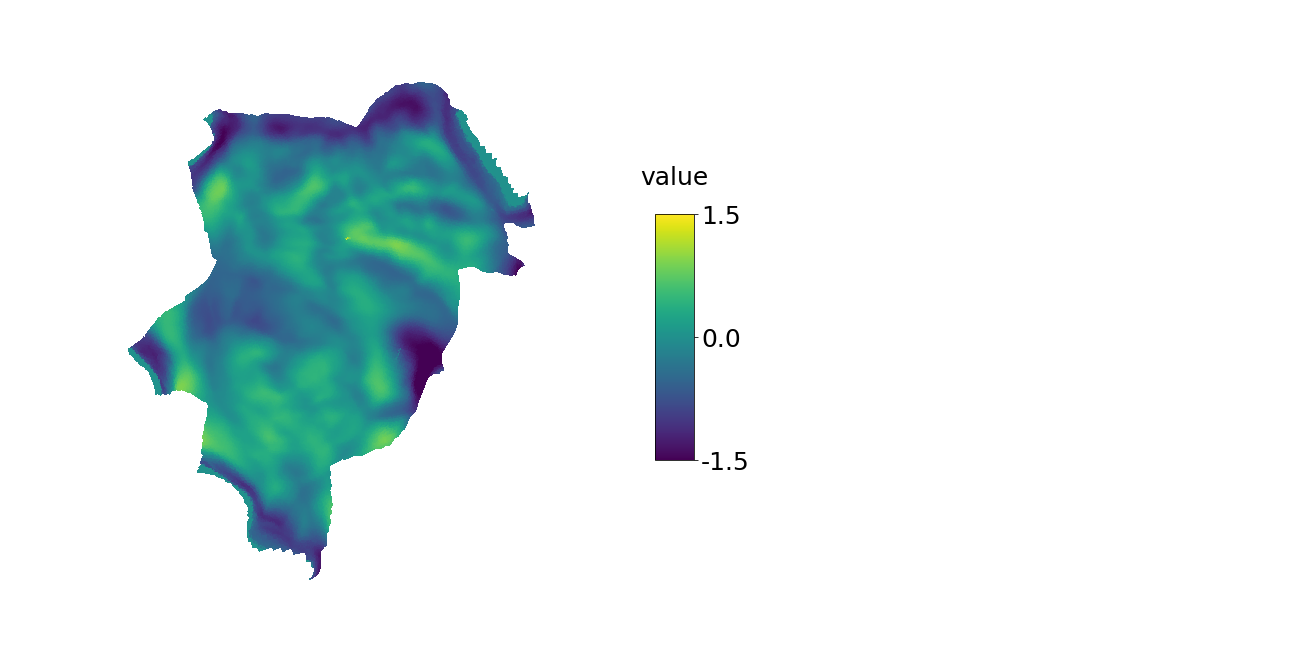

In [8]:
import matplotlib_surface_plotting as msp
import nibabel as nb

vals = vals_new

# plt.hist(vals, color='red')
print(vals.min())
print(vals.mean())
print(np.median(vals))
print(vals.max())

flat = nb.load(os.path.join(BASE_PATH, "fsaverage_sym", "surf", "lh.full.patch.flat.gii"))

vertices, faces = flat.darrays[0].data, flat.darrays[1].data
msp.plot_surf(vertices,faces, vals , flat_map=True,base_size=10,
            vmin=-1.5,vmax=1.5
             )

In [77]:
vals=np.clip(vals_h29, np.percentile(vals_h29,5), np.percentile(vals_h29, 95))

In [79]:
import h5py

hdf5_file= '/rds/project/kw350/rds-kw350-meld/meld_data/Data/MELD_H29/H29_patient_featurematrix.hdf5'
r=    h5py.File(hdf5_file, "r+")
hdf5_file= '/rds/project/kw350/rds-kw350-meld/meld_data/Data/MELD_H29/H29_patient_featurematrix_old.hdf5'
r_old=    h5py.File(hdf5_file, "r+")

In [85]:
subject = 'MELD_H29_3T_FCD_0052'
feat_new = r['H29']['3T']['patient'][subject]['rh']['.on_lh.pial.K_filtered.sm20.mgh'][:]
feat_old = r_old['H29']['3T']['patient'][subject]['rh']['.on_lh.pial.K_filtered.sm20.mgh'][:]

In [81]:
np.corrcoef(feat_new,feat_old)

array([[1.        , 0.17292589],
       [0.17292589, 1.        ]])

0.0
0.33716643
0.32999554
8.02338


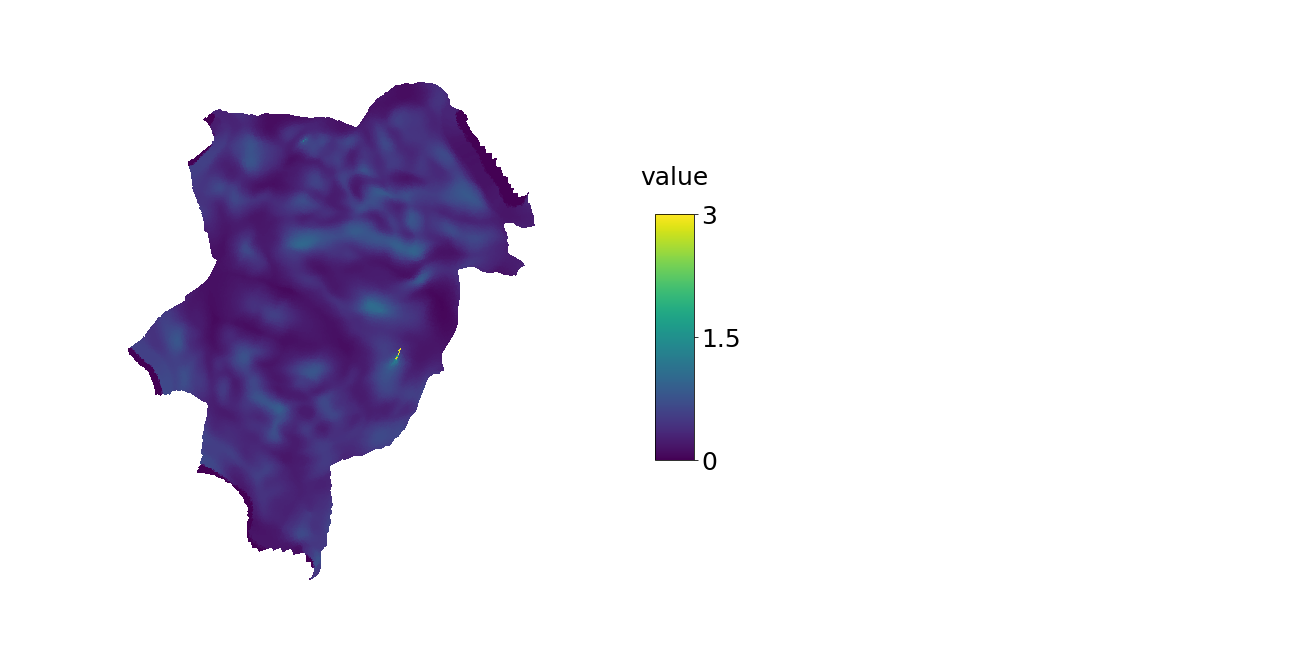

In [83]:
import matplotlib_surface_plotting as msp
import nibabel as nb

vals = feat_new

# plt.hist(vals, color='red')
print(vals.min())
print(vals.mean())
print(np.median(vals))
print(vals.max())

flat = nb.load(os.path.join(BASE_PATH, "fsaverage_sym", "surf", "lh.full.patch.flat.gii"))

vertices, faces = flat.darrays[0].data, flat.darrays[1].data
msp.plot_surf(vertices,faces, vals , flat_map=True,base_size=10,
            vmin=0,vmax=3
             )

In [10]:
feat_new.max()

13.611611

In [13]:
import h5py

hdf5_file= '/rds/project/kw350/rds-kw350-meld/test_meld/output/preprocessed_surf_data/MELD_H29/H29_patient_featurematrix_combat.hdf5'
r=    h5py.File(hdf5_file, "r+")
hdf5_file= '/rds/project/kw350/rds-kw350-meld/test_meld/output/preprocessed_surf_data/MELD_H29/H29_patient_featurematrix_combat_ref.hdf5'
r_old=    h5py.File(hdf5_file, "r+")

In [ ]:
subject = 'MELD_H29_3T_FCD_0079'
feat_new = r['H29']['3T']['patient'][subject]['lh']['.inter_z.intra_z.combat.on_lh.thickness.sm10.mgh'][:]
feat_old = r_old['H29']['3T']['patient'][subject]['lh']['.inter_z.intra_z.combat.on_lh.thickness.sm10.mgh'][:]

In [111]:
np.corrcoef(feat_new,feat_old)

array([[1., 1.],
       [1., 1.]])

In [37]:
### test on the whole H29 cohort
site_codes=['H29']
c_new =  MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat.hdf5', dataset='MELD_dataset_test_distributed.csv')
c_ref =  MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_ref.hdf5', dataset='MELD_dataset_test_distributed.csv')
listids = c_ref.get_subject_ids(site_codes=site_codes, lesional_only=False)

features = [
# ".combat.on_lh.thickness.sm10.mgh",
# ".combat.on_lh.w-g.pct.sm10.mgh",
".combat.on_lh.pial.K_filtered.sm20.mgh",
# '.combat.on_lh.sulc.sm5.mgh',
# '.combat.on_lh.curv.sm5.mgh',
# '.combat.on_lh.gm_FLAIR_0.25.sm10.mgh',
# '.combat.on_lh.gm_FLAIR_0.5.sm10.mgh',
# '.combat.on_lh.gm_FLAIR_0.75.sm10.mgh',
# ".combat.on_lh.gm_FLAIR_0.sm10.mgh",
# '.combat.on_lh.wm_FLAIR_0.5.sm10.mgh',
# '.combat.on_lh.wm_FLAIR_1.sm10.mgh',
]


hemi= 'rh'
for feature in features:
    corr_all=[]
    vals_new=[]
    vals_ref=[]
    for k, subject in enumerate(listids):
        #get features values new
        subj_new = MeldSubject(subject, cohort=c_new)
        val_new = subj_new.load_feature_values(feature, hemi=hemi)
        vals_new.append(val_new)

        #get features values reference
        subj_ref = MeldSubject(subject, cohort=c_ref)
        val_ref = subj_ref.load_feature_values(feature, hemi=hemi)
        vals_ref.append(val_ref)

        #correlation
        if (val_new.sum()!=0) and (val_ref.sum()!=0):
            corr = np.corrcoef(val_new,val_ref)[0,1]
            corr_all.append(corr)
    
    print(feature)
    print(f'mean correlation : {np.array(corr_all).mean()}')
    print(f'std correlation : {np.array(corr_all).std()}')
        

.combat.on_lh.pial.K_filtered.sm20.mgh
mean correlation : 0.8380039123201015
std correlation : 0.21003757649362784


In [33]:
listids[2]

'MELD_H29_3T_FCD_0052'

[0.284775   0.21148275 0.46319225 ... 0.57446367 0.6242372  0.66197616]
[0.23145455 0.21344942 0.52690905 ... 0.5125823  0.551138   0.579876  ]


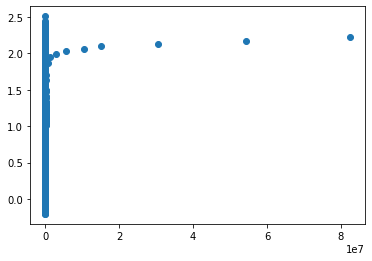

In [38]:
i=2
print(vals_new[i])
print(vals_ref[i])
np.corrcoef(vals_ref[i], vals_new[i])
plt.scatter(vals_ref[i], vals_new[i])

(array([1.7584e+04, 3.6762e+04, 6.4545e+04, 3.0115e+04, 1.1360e+04,
        2.3690e+03, 8.8800e+02, 1.5000e+02, 5.3000e+01, 1.6000e+01]),
 array([-0.17892405,  0.04615732,  0.27123868,  0.49632007,  0.72140145,
         0.9464828 ,  1.1715641 ,  1.3966455 ,  1.6217269 ,  1.8468083 ,
         2.0718896 ], dtype=float32),
 <BarContainer object of 10 artists>)

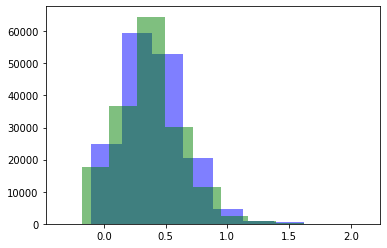

In [18]:
plt.hist(vals_new[i], color='blue',alpha=0.5)
plt.hist(vals_ref[i], color='green',alpha=0.5)

-0.20272909
0.36722416
0.3453626
2.5071056


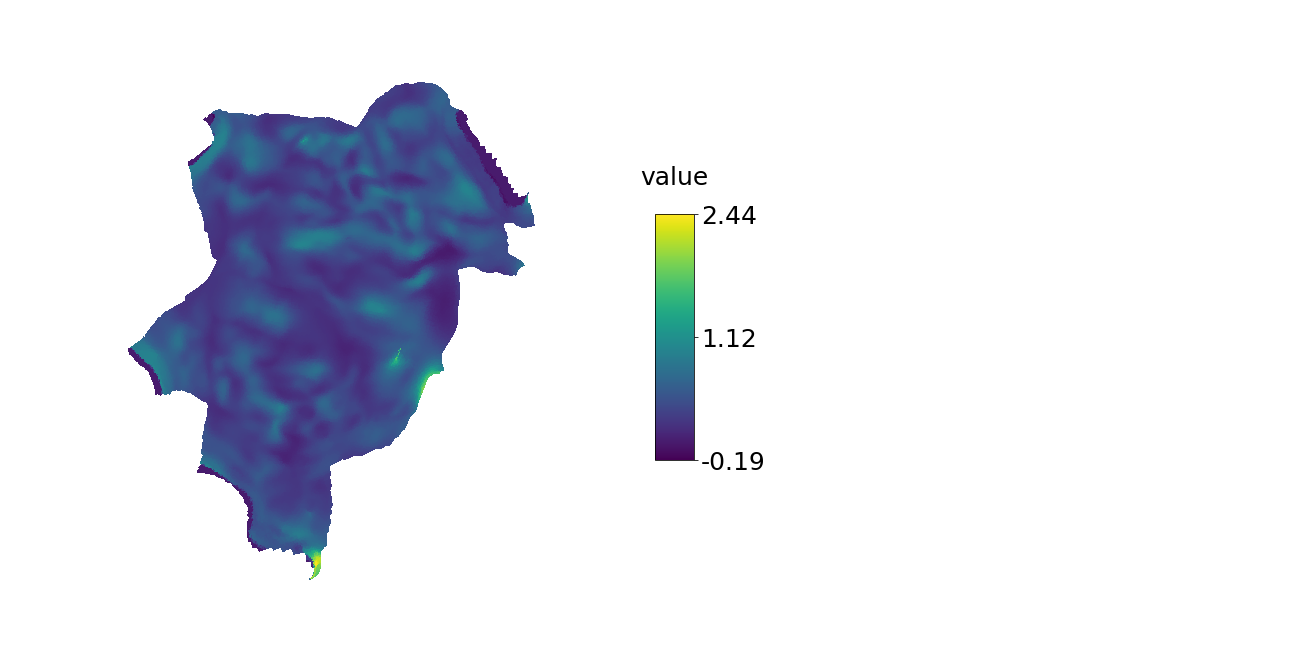

In [39]:
import matplotlib_surface_plotting as msp
import nibabel as nb

vals = vals_new[i]

# plt.hist(vals, color='red')
print(vals.min())
print(vals.mean())
print(np.median(vals))
print(vals.max())

flat = nb.load(os.path.join(BASE_PATH, "fsaverage_sym", "surf", "lh.full.patch.flat.gii"))

vertices, faces = flat.darrays[0].data, flat.darrays[1].data
msp.plot_surf(vertices,faces, vals , flat_map=True,base_size=10,
             )

In [10]:
#old combat
def combat_new_site(
        self,
        feature_name,
        new_site_code,
        ref_cohort,
        new_outliers_file=None,
    ):
        """Harmonise new site data to post-combat whole cohort and save in
        new hdf5 file. New sites are run individually currently.
        assumes that the base cohort is the post-combat cohort
        Args:
            feature_name (str): name of the feature
            outliers_file : outliers file for the new cohort

        """
        # read morphological outliers from new cohort only
        if new_outliers_file is not None:
            outliers = list(pd.read_csv(os.path.join(BASE_PATH, new_outliers_file), header=0)["ID"])
        else:
            outliers = []

        # make empty for all subjects
        ref_subject_ids = ref_cohort.get_subject_ids(lesional_only=False)
        combined_ids = ref_subject_ids + self.subject_ids
        combat_subject_include = np.zeros(len(combined_ids), dtype=bool)
        new_site_codes = np.ones(len(combined_ids), dtype=int)
        new_site_codes[: len(ref_subject_ids)] = 0
        # load in both combat normalised and new cohort
        precombat_features = []
        cohorts = [ref_cohort, self.cohort]
        # need pre combat and post combat feature names, loading in post for the whole cohort,
        # pre for the new cohort.
        post_combat_feature_name = self.feat.combat_feat(feature_name)
        feature_names = [post_combat_feature_name, feature_name]
        for k, subject in enumerate(combined_ids):
            # get the reference index and cohort object for the site, 0 whole cohort, 1 new cohort
            site_code_index = new_site_codes[k]
            cohort = cohorts[site_code_index]
            subj = MeldSubject(subject, cohort=cohort)
            # exclude outliers and subject without feature
            if (subj.has_features(feature_names[site_code_index])) & (subject not in outliers):
                lh = subj.load_feature_values(feature_names[site_code_index], hemi="lh")[self.cohort.cortex_mask]
                rh = subj.load_feature_values(feature_names[site_code_index], hemi="rh")[self.cohort.cortex_mask]
                combined_hemis = np.hstack([lh, rh])
                precombat_features.append(combined_hemis)
                combat_subject_include[k] = True
            else:
                combat_subject_include[k] = False
        if precombat_features:
            precombat_features = np.array(precombat_features)
            # load in covariates - age, sex, group, site and scanner,
            # set site_scanner to 0 for existing cohort
            covars = pd.concat([self.load_covars(ref_subject_ids), self.covars])
            covars["site_scanner"][: len(ref_subject_ids)] = "H0"
            covars = covars[combat_subject_include].copy()

            # function to check for single subjects
            covars, precombat_features = self.remove_isolated_subs(covars, precombat_features)

            dict_combat = nc.neuroCombat(
                precombat_features.T,
                covars,
                batch_col="site_scanner",
                categorical_cols=["sex", "group"],
                continuous_cols=["ages"],
                ref_batch="H0",
            )

            print("Combat finished \n Saving data")
            # only save out new subjects
            ids_to_save = np.array(covars[covars["site_scanner"] != "H0"]["ID"])
            return dict_combat["data"].T[covars["site_scanner"] != "H0"]
            

In [5]:
#sys.path.append('../../neuroCombat/distributedCombat/')
import meld_classifier.distributedCombat as dc

In [6]:
import neuroCombat as nc


In [8]:
#get full combat thing
preprocessor=Preprocess(c_combat)

In [9]:
#calculate distributed combat parameters for central site
#check size
#calculated distributed combat parameters for ref site

#run combat

In [10]:
#load in precombat data
ref_subject_ids = c_combat.get_subject_ids(lesional_only=False)
new_site_codes=np.zeros(len(ref_subject_ids))
precombat_features=[]
combat_subject_include = np.zeros(len(ref_subject_ids), dtype=bool)

for k, subject in enumerate(ref_subject_ids):
    # get the reference index and cohort object for the site, 0 whole cohort, 1 new cohort
    site_code_index = new_site_codes[k]
    
    subj = MeldSubject(subject, cohort=c_combat)
    # exclude outliers and subject without feature
    if (subj.has_features('.combat.on_lh.thickness.sm10.mgh')) :
        lh = subj.load_feature_values('.combat.on_lh.thickness.sm10.mgh', hemi="lh")[c_combat.cortex_mask]
        rh = subj.load_feature_values('.combat.on_lh.thickness.sm10.mgh', hemi="rh")[c_combat.cortex_mask]
        combined_hemis = np.hstack([lh, rh])
        precombat_features.append(combined_hemis)
        combat_subject_include[k] = True
    else:
        combat_subject_include[k] = False

#calculate distributed combat parameters for central site
precombat_features = np.array(precombat_features).T


In [11]:
new_site_code = 'H29'


In [12]:
covars = preprocessor.load_covars(ref_subject_ids)

covars = covars[combat_subject_include].copy()
covars = covars.reset_index()
N=len(covars)
bat = pd.Series(pd.Categorical(np.repeat('H0', N), categories=['H0', new_site_code]))

covars['site_scanner']=bat
covars = covars[['ages','sex','group','site_scanner']]
# for c in ['ages','sex','group']:
#     covars[c] = covars[c].astype(np.float64)

/home/kw350/software/main_meld/meld_classifier/meld_classifier/data_preprocessing.py:129: FutureWarning: Dropping invalid columns in DataFrameGroupBy.transform is deprecated. In a future version, a TypeError will be raised. Before calling .transform, select only columns which should be valid for the transforming function.
  covars["ages"] = covars.groupby("site_scanner").transform(lambda x: x.fillna(x.mean()))["ages"]


In [13]:
#use var estimates from basic combat
com_out = nc.neuroCombat(precombat_features, covars, 'site_scanner')
with open('MELD_var.pickle', "wb") as f:
    pickle.dump(com_out['estimates']['var.pooled'], f)


[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments


/home/kw350/software/main_meld/neuroCombat/neuroCombat/neuroCombat.py:324: RuntimeWarning: divide by zero encountered in true_divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


[neuroCombat] Final adjustment of data


In [14]:
#calculate reference estimates for distributed combat
_ = dc.distributedCombat_site(precombat_features, bat, covars[['ages','sex','group']], 
                          file='MELD.pickle', ref_batch = 'H0')


{'ls_site': [array([[944, 0.0, 23725.221764705886, 445.0, 571],
         [0.0, 0.0, 0.0, 0.0, 0.0],
         [23725.221764705886, 0.0, 789041.592005191, 11023.880000000005,
          12905.221764705886],
         [445.0, 0.0, 11023.880000000005, 445.0, 281.0],
         [571, 0.0, 12905.221764705886, 281.0, 571]], dtype=object),
  array([[2643.5596737861633, 2435.3595724105835, 2539.5392149686813, ...,
          2965.045336127281, 2963.4483358860016, 2960.173226714134],
         [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
         [66334.75930531249, 59975.292315540835, 62089.316403753786, ...,
          74319.31836403435, 74276.7197474132, 74190.13579773683],
         [1239.3644975423813, 1142.9102636575699, 1191.7604579925537, ...,
          1375.2028512954712, 1372.8655278682709, 1370.22782766819],
         [1585.3471558094025, 1473.0717936754227, 1540.9511893987656, ...,
          1777.7451092004776, 1778.9316754341125, 1778.9515227079391]],
        dtype=object)],
 'data_dict': {'batch': 

In [15]:
#dummy new site data
#get real new site data

new_site_data = precombat_features[:,:20]
new_site_covars = covars.loc[:19]
new_site_covars['site_scanner']='H27'
N=len(new_site_covars)
bat = pd.Series(pd.Categorical(np.repeat(new_site_code, N),
                               categories=['H0', new_site_code]))


/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [16]:
_=dc.distributedCombat_site(new_site_data,
                          bat, 
                          new_site_covars[['ages','sex','group']], 
                          file="new_site_summary.pickle", 
                          ref_batch = 'H0')



In [17]:
dc_out = dc.distributedCombat_central(
    ["MELD.pickle", "new_site_summary.pickle"], ref_batch = 'H0'
)

Must specify filename to output results as a file. Currently saving output to current workspace only.


In [18]:
# third, use variance estimates from full MELD cohort
dc_out['var_pooled'] = pd.read_pickle('MELD_var.pickle').ravel()


In [19]:
new_site_covars[['ages','sex','group']]
for c in ['ages','sex','group']:
    new_site_covars[c]=new_site_covars[c].astype(np.float64)


/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,ages,sex,group,site_scanner
0,21.00,1.0,1.0,H27
1,26.00,1.0,1.0,H27
2,25.00,1.0,1.0,H27
3,31.00,0.0,1.0,H27
4,25.75,0.0,1.0,H27
5,23.00,0.0,1.0,H27
6,30.00,1.0,1.0,H27
7,21.00,0.0,1.0,H27
8,38.00,0.0,1.0,H27
9,45.00,0.0,1.0,H27


In [20]:
_=dc.distributedCombat_site(
    pd.DataFrame(new_site_data), bat, new_site_covars[['ages','sex','group']], 
    file="new_site_harmonized.pickle",
     central_out=dc_out, 
    ref_batch = 'H0'
)


/home/kw350/software/main_meld/meld_classifier/meld_classifier/distributedCombat_helpers.py:229: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  np.linalg.inv(np.matmul(batch_design.transpose(), batch_design)),
/home/kw350/software/main_meld/meld_classifier/meld_classifier/distributedCombat_helpers.py:232: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames

{'dat_combat':               0         1         2         3         4         5         6   \
 0       2.595635  2.097938  3.026401  3.006287  2.896137  3.198391  2.897986   
 1       2.463568  2.396726  2.765514  2.309976  2.887334  2.317723  2.747328   
 2       2.826228  2.674310  2.865000  2.223642  2.794088  2.300700  2.202705   
 3       2.331012  2.464350  2.418239  3.056799  2.389323  2.165172  2.220407   
 4       2.924268  3.103857  2.582707  3.375710  3.176956  3.181451  2.834421   
 ...          ...       ...       ...       ...       ...       ...       ...   
 293799  2.437880  2.671439  3.144954  3.660862  3.169304  4.145481  3.260040   
 293800  2.424257  2.682000  3.195341  3.639781  3.214105  4.160335  3.291214   
 293801  2.409653  2.694118  3.240368  3.620041  3.254245  4.168916  3.323698   
 293802  2.377067  2.661448  3.212721  3.623532  3.270908  4.182988  3.381572   
 293803  2.348620  2.632386  3.182702  3.622817  3.282910  4.187874  3.432968   
 
            

In [22]:
done=pickle.load(open('new_site_harmonized.pickle', "rb"))
done['estimates']['gamma_star']

array([-0.01966927, -0.09759911, -0.111213  , ...,  0.09385213,
        0.08295549,  0.07320043])

In [140]:
new_sites=['H29']
c_raw = MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_smoothed_NewSite.hdf5', dataset='MELD_dataset_NewSiteH29.csv',
                  data_dir=MELD_DATA_PATH)
listids = c_raw.get_subject_ids(site_codes=new_sites, lesional_only=False)



In [141]:
preprocessor=Preprocess(c_raw)
DEMOGRAPHIC_FEATURES_FILE = "demographics_qc_allgroups_with_H29.csv"

precombat_features=[]
combat_subject_include = np.zeros(len(listids), dtype=bool)
demos=[]
for k, subject in enumerate(listids):
    # get the reference index and cohort object for the site, 0 whole cohort, 1 new cohort
    site_code_index = new_site_codes[k]
    
    subj = MeldSubject(subject, cohort=c_raw)
    demo = subj.get_demographic_features(['Age at preop','Sex','group',],
                                         csv_file = DEMOGRAPHIC_FEATURES_FILE)
    demo[2]=demo[2]=='patient'
    demos.append(demo)
    # exclude outliers and subject without feature
    if (subj.has_features('.on_lh.thickness.sm10.mgh')) :
        lh = subj.load_feature_values('.on_lh.thickness.sm10.mgh', hemi="lh")[c_raw.cortex_mask]
        rh = subj.load_feature_values('.on_lh.thickness.sm10.mgh', hemi="rh")[c_raw.cortex_mask]
        combined_hemis = np.hstack([lh, rh])
        precombat_features.append(combined_hemis)
        combat_subject_include[k] = True
    else:
        combat_subject_include[k] = False

#calculate distributed combat parameters for central site
new_site_data = np.array(precombat_features).T
demos = np.array(demos).astype(np.float64)
demos = demos[combat_subject_include]


In [142]:

new_site_covars = pd.DataFrame(demos,columns=['ages','sex','group'])
new_site_covars = new_site_covars.reset_index()
N=len(new_site_covars)
bat = pd.Series(pd.Categorical(np.repeat(new_site_code, N),
                               categories=['H0', new_site_code]))

new_site_covars['site_scanner']=bat
new_site_covars = new_site_covars[['ages','sex','group','site_scanner']]

In [157]:
print('step1')
dc.distributedCombat_site(new_site_data,
                          bat, 
                          new_site_covars[['ages','sex','group']], 
                          file="new_site_summary.pickle", 
                      ref_batch = 'H0')
print('step2')

dc_out = dc.distributedCombat_central(
    ["MELD.pickle", "new_site_summary.pickle"], ref_batch = 'H0'
)
# third, use variance estimates from full MELD cohort


step1
step2
Must specify filename to output results as a file. Currently saving output to current workspace only.


In [158]:

dc_out['var_pooled'] = pd.read_pickle('MELD_var.pickle').ravel()
new_site_covars[['ages','sex','group']]
for c in ['ages','sex','group']:
    new_site_covars[c]=new_site_covars[c].astype(np.float64)
print('step3')

_=dc.distributedCombat_site(
    pd.DataFrame(new_site_data), bat, new_site_covars[['ages','sex','group']], 
    file="new_site_harmonized.pickle",
     central_out=dc_out, 
    ref_batch = 'H0'
)

step3


/home/kw350/software/main_meld/meld_classifier/meld_classifier/distributedCombat_helpers.py:229: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  np.linalg.inv(np.matmul(batch_design.transpose(), batch_design)),
/home/kw350/software/main_meld/meld_classifier/meld_classifier/distributedCombat_helpers.py:232: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames

In [144]:
h29=pickle.load(open('new_site_harmonized.pickle', "rb"))


In [145]:
import h5py
f='/rds/user/kw350/rds-kw350-meld/meld_data/Data/Combat_parameters_6_shrink_with_H29.hdf5'

In [146]:
#f='/rds/user/kw350/rds-kw350-meld/meld_data/Data/Combat_parameters_6_shrink.hdf5'

In [147]:

r=    h5py.File(f, "r+")
print(r.keys())

<KeysViewHDF5 ['.on_lh.curv.sm5.mgh', '.on_lh.gm_FLAIR_0.25.sm10.mgh', '.on_lh.gm_FLAIR_0.5.sm10.mgh', '.on_lh.gm_FLAIR_0.75.sm10.mgh', '.on_lh.gm_FLAIR_0.sm10.mgh', '.on_lh.pial.K_filtered.sm20.mgh', '.on_lh.sulc.sm5.mgh', '.on_lh.thickness.sm10.mgh', '.on_lh.w-g.pct.sm10.mgh', '.on_lh.wm_FLAIR_0.5.sm10.mgh', '.on_lh.wm_FLAIR_1.sm10.mgh']>


In [148]:
h29['estimates'].keys()

dict_keys(['gamma_hat', 'delta_hat', 'gamma_star', 'delta_star', 'gamma_bar', 't2', 'a_prior', 'b_prior', 'stand_mean', 'mod_mean', 'var_pooled', 'beta_hat', 'mod', 'batch', 'ref_batch', 'eb', 'parametric', 'mean_only'])

In [149]:
r['.on_lh.thickness.sm10.mgh'].keys()

<KeysViewHDF5 ['a_prior', 'b_prior', 'batches', 'delta.star', 'delta_hat', 'gamma.star', 'gamma_bar', 'gamma_hat', 'stand.mean', 't2', 'var.pooled']>

In [150]:
dict_trans = {  'var_pooled' :'var.pooled', 'stand_mean':'stand.mean',
             'gamma_star':'gamma.star',
              'delta_star':'delta.star'
    
}

In [151]:
h29['estimates']['gamma_star']

array([-0.29803439,  0.16412822,  1.1110283 , ..., -0.32362026,
       -0.26585187, -0.22648567])

In [152]:
r['.on_lh.thickness.sm10.mgh']['gamma.star'][:]

array([[-0.02535067, -0.74980438, -0.95659354, ...,  0.18538668,
         0.14399838,  0.11005745],
       [ 0.12462134, -0.05315445,  0.19109114, ...,  0.23696148,
         0.19060924,  0.15195985],
       [-0.59141207, -0.47368598, -0.57783468, ..., -0.38959143,
        -0.46579725, -0.53311225],
       ...,
       [-0.25978467, -0.29191566, -0.23886391, ..., -0.05283375,
        -0.05584079, -0.05809188],
       [-0.90145029, -0.31910456, -1.12513365, ..., -0.83040208,
        -0.79822555, -0.76691451],
       [ 0.770907  ,  0.15374313,  0.40022076, ...,  0.17672618,
         0.19807367,  0.21465289]])

In [153]:
for i,s in enumerate(r['.on_lh.thickness.sm10.mgh']['batches'].attrs["values"].astype(np.str)):
    print(i,s,np.corrcoef(h29['estimates']['delta_star'],
           r['.on_lh.thickness.sm10.mgh']['delta.star'][i])[0,1],
      np.corrcoef(h29['estimates']['gamma_star'],
           r['.on_lh.thickness.sm10.mgh']['gamma.star'][i])[0,1],
     )

/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


0 H10_3T -0.17512065469221436 -0.46076543021061256
1 H11_3T 0.08613978095634695 0.010672936773568292
2 H12_15T -0.11011650497637472 -0.29329712509459055
3 H12_3T 0.15478424337310942 -0.4618730773021159
4 H14_3T 0.04596097762653507 -0.08606652687193211
5 H15_3T -0.022917329599929 0.05862722115331445
6 H16_3T -0.011435288837346702 -0.38140162178564674
7 H17_15T -0.017434629413527167 -0.30617652592195443
8 H17_3T -0.1753136814625555 -0.30456195274687564
9 H18_3T 0.08101200389555117 0.2543102877045795
10 H19_3T -0.1278279511238725 -0.22684608615719135
11 H21_15T 0.04421857739202991 0.3350154904011703
12 H21_3T 0.006750909155078071 0.2960732567372143
13 H23_15T -0.13743501391357327 0.13055858643521573
14 H24_3T 0.10240205590949543 0.40669525998134837
15 H26_15T 0.1621785015042939 -0.22876901508884642
16 H26_3T -0.10375838230130928 -0.13925404907700858
17 H29_3T 0.9482784522174545 0.9963710927184899
18 H2_15T -0.03973727756104102 -0.08125715456205024
19 H2_3T 0.12166692323687696 0.0290553394

In [132]:
np.where(r['.on_lh.thickness.sm10.mgh']['batches'].attrs["values"].astype(np.str)==['H29_3T'])

/home/kw350/.conda/envs/meld_classifier/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


(array([17]),)

In [90]:
h29['estimates']['var_pooled']

array([0.13729922, 0.13914082, 0.10271709, ..., 0.21593729, 0.22392766,
       0.23028035])

In [112]:
for k in dict_trans.keys():
    print(k,h29['estimates'][k].shape,r['.on_lh.thickness.sm10.mgh'][dict_trans[k]].shape)

var_pooled (293804,) (293804, 1)
stand_mean (293804, 52) (293804,)
gamma_star (293804,) (27, 293804)
delta_star (293804,) (27, 293804)


In [97]:
from meld_classifier import distributedCombat_helpers as helpers

def distributedCombat_site(
    dat,
    batch,
    mod=None,
    ref_batch=None,
    central_out=None,
    eb=True,
    parametric=True,
    mean_only=False,
    verbose=False,
    file=None,
):
    if file is None:
        file = "distributedCombat_site.pickle"
        print(
            "Must specify filename to output results as a file. Currently saving output to current workspace only."
        )
    if isinstance(central_out, str):
        central_out = pd.read_pickle(central_out)
    hasNAs = np.isnan(dat).any(axis=None)
    if verbose and hasNAs:
        print("[neuroCombat] WARNING: NaNs detected in data")
    if mean_only:
        print("[neuroCombat] Performing ComBat with mean only")

    ##################### Getting design ############################
    data_dict = helpers.getDataDictDC(
        batch, mod, verbose=verbose, mean_only=mean_only, ref_batch=ref_batch
    )

    design = data_dict["design"].copy()
    #################################################################

    ############### Site matrices for standardization ###############
    # W^T W used in LS estimation
    ls_site = []
    ls_site.append(np.dot(design.transpose(), design))
    ls_site.append(np.dot(design.transpose(), dat.transpose()))

    data_dict_out = data_dict.copy()
    data_dict_out["design"] = None

    # new data_dict with batches within current site
    incl_bat = [x > 0 for x in data_dict["n_batches"]]
    data_dict_site = data_dict.copy()
    data_dict_site["batches"] = [
        data_dict["batches"][i] for i in range(len(data_dict["batches"])) if incl_bat[i]
    ]
    data_dict_site["n_batch"] = incl_bat.count(True)
    data_dict_site["n_batches"] = [
        data_dict["n_batches"][i]
        for i in range(len(data_dict["n_batches"]))
        if incl_bat[i]
    ]
    data_dict_site["batch_design"] = data_dict["batch_design"].loc[:, incl_bat]

    # remove reference batch information if reference batch is not in site
    if ref_batch is not None:
        if data_dict_site["ref"] in data_dict_site["batch"].unique():
            data_dict_site["ref"] = np.where(
                np.any(data_dict_site["batch"] == ref_batch)
            )[0][0]
        else:
            data_dict_site["ref"] = None
            data_dict_site["ref_batch"] = None

    if central_out is None:
        site_out = {
            "ls_site": ls_site,
            "data_dict": data_dict,
            "sigma_site": None,
        }
        with open(file, "wb") as handle:
            pickle.dump(site_out, handle, protocol=pickle.HIGHEST_PROTOCOL)
        return site_out

    # If beta.estimates given, get summary statistics for sigma estimation

    if "var_pooled" not in central_out or central_out["var_pooled"] is None:
        sigma_site = helpers.getSigmaSummary(dat, data_dict, design, hasNAs, central_out)
        site_out = {
            "ls_site": ls_site,
            "data_dict": data_dict,
            "sigma_site": sigma_site,
        }
        with open(file, "wb") as handle:
            pickle.dump(site_out, handle, protocol=pickle.HIGHEST_PROTOCOL)
        return site_out

    stdObjects = helpers.getStandardizedDataDC(
        dat=dat,
        data_dict=data_dict,
        design=design,
        hasNAs=hasNAs,
        central_out=central_out,
    )
    s_data = stdObjects["s_data"]
    return s_data,data_dict


In [98]:
s_data,data_dict=distributedCombat_site(
    new_site_data, bat, new_site_covars[['ages','sex','group']], 
    file="new_site_harmonized.pickle",
     central_out=dc_out, 
    ref_batch = 'H0'
)


In [104]:
batches = data_dict["batches"]
i=batches[1]

In [132]:
v=np.var(s_data.iloc[:100, i[0]].astype(np.float64),axis=1,ddof=1)

v1=np.diagonal(np.cov(s_data.iloc[:100, i[0]].astype(np.float64), rowvar=True))

In [135]:
v1-v

0     2.220446e-16
1     0.000000e+00
2     0.000000e+00
3    -1.110223e-16
4    -2.220446e-16
          ...     
95    0.000000e+00
96    0.000000e+00
97   -2.220446e-16
98    0.000000e+00
99   -2.220446e-16
Length: 100, dtype: float64

In [ ]:
done=pickle.load(open('new_site_harmonized.pickle', "rb"))

In [ ]:
#step 1 calculates something. Outputs 2 pickle files

In [19]:
#step 1
batch_col = "site_scanner"
site_outs = []
outs=[]
batch = pd.Series(covars[batch_col],dtype="category")
for b in covars[batch_col].unique():
    s = list(map(lambda x: x == b, covars[batch_col]))
    df = pd.DataFrame(precombat_features[:, s])
    bat = batch[s]
    mod=covars[['ages','sex','group']][s]
    f = "site_out_" + str(b) + "step1.pickle"
    out = dc.distributedCombat_site(df, bat, mod, verbose=True, file=f, ref_batch="H0")
    site_outs.append(f)
    outs.append(out)

[combat] Found 2 batches
[combat] Using batch=H0 as a reference batch
[combat] Adjusting for  3  covariate(s) or covariate level(s)
[combat] Found 2 batches
[combat] Using batch=H0 as a reference batch
[combat] Adjusting for  3  covariate(s) or covariate level(s)


In [20]:
# ls1 = np.array([x["ls_site"][0] for x in outs],dtype=float)
# ls2 = np.array([x["ls_site"][1] for x in outs],dtype=float)
# ls1 = np.cumsum(ls1, axis=0)[-1]
# ls2 = np.cumsum(ls2, axis=0)[-1]
# B_hat = np.matmul(np.transpose(np.linalg.inv(ls1)), ls2)


In [21]:
central = dc.distributedCombat_central(site_outs,
                                                         ref_batch="H0")


Must specify filename to output results as a file. Currently saving output to current workspace only.


In [30]:
central

{'B_hat': array([[ 2.87273836e+00,  2.76082726e+00,  2.94237274e+00, ...,
          3.27097790e+00,  3.26482042e+00,  3.25678282e+00],
        [ 2.43385064e-02,  2.62450668e-02,  2.83698883e-03, ...,
          1.14721933e-02,  9.84297745e-03,  8.66022892e-03],
        [-1.31384290e-03, -6.43232527e-03, -8.84719894e-03, ...,
         -1.85443642e-03, -1.75913807e-03, -1.68640889e-03],
        [-2.48058980e-02, -1.98598958e-02, -2.29820715e-02, ...,
         -9.17674098e-02, -9.89966526e-02, -1.04134338e-01],
        [-6.53136787e-02, -3.60148342e-02, -3.09331465e-02, ...,
         -7.54054490e-02, -6.50532748e-02, -5.55797672e-02]]),
 'stand_mean': array([[2.87273836, 2.87273836, 2.87273836, ..., 2.87273836, 2.87273836,
         2.87273836],
        [2.76082726, 2.76082726, 2.76082726, ..., 2.76082726, 2.76082726,
         2.76082726],
        [2.94237274, 2.94237274, 2.94237274, ..., 2.94237274, 2.94237274,
         2.94237274],
        ...,
        [3.2709779 , 3.2709779 , 3.2709779 ,

In [31]:
mod

,ages,sex,group
0,21.00,1.0,True
1,26.00,1.0,True
2,25.00,1.0,True
3,31.00,0.0,True
4,25.75,0.0,True
...,...,...,...
470,53.00,1.0,True
471,6.50,1.0,False
472,14.25,0.0,False
473,14.00,0.0,False


In [32]:
mod

,ages,sex,group
0,21.00,1.0,True
1,26.00,1.0,True
2,25.00,1.0,True
3,31.00,0.0,True
4,25.75,0.0,True
...,...,...,...
470,53.00,1.0,True
471,6.50,1.0,False
472,14.25,0.0,False
473,14.00,0.0,False


In [22]:


### Step 2
site_outs = []
for b in covars[batch_col].unique():
    s = list(map(lambda x: x == b, covars[batch_col]))
    df = pd.DataFrame(precombat_features[:, s])
    bat = batch[s]
    mod = covars[['ages','sex','group']][s]  
    f = "site_out_" + str(b) + "step2.pickle"
    out = dc.distributedCombat_site(
        df, bat, mod, verbose=True, central_out=central, file=f, ref_batch="H0"
    )
    site_outs.append(f)

central = dc.distributedCombat_central(site_outs, ref_batch="H0")


[combat] Found 2 batches
[combat] Using batch=H0 as a reference batch
[combat] Adjusting for  3  covariate(s) or covariate level(s)


AssertionError: Number of manager items must equal union of block items
# manager items: 5, # tot_items: 293804

In [ ]:
#step 3 get the data out
b = 'H1'
s = list(map(lambda x: x == b, covars[batch_col]))
df = pd.DataFrame(precombat_features[:, s])
bat = batch[s]
mod = covars[['ages','sex','group']][s]  
f = "site_out_" + str(b) + ".pickle"
out = dc.distributedCombat_site(
        df, bat, x, central_out=central, file=f, ref_batch="H0"
    )

In [ ]:
site_outs = []
for b in covars[batch_col].unique():
    s = list(map(lambda x: x == b, covars[batch_col]))
    df = dat.loc[:, s]
    bat = covars[batch_col][s]
    x = mod.loc[s, :]
    f = "site_out_" + str(b) + ".pickle"
    out = dc.distributedCombat_site(df, bat, x, verbose=True, file=f, ref_batch="1")
    site_outs.append(f)


In [ ]:
ref_subject_ids = c_combat.get_subject_ids(lesional_only=False)
combined_ids = ref_subject_ids + self.subject_ids
combat_subject_include = np.zeros(len(combined_ids), dtype=bool)
new_site_codes = np.ones(len(combined_ids), dtype=int)
new_site_codes[: len(ref_subject_ids)] = 0
# load in both combat normalised and new cohort
precombat_features = []
cohorts = [ref_cohort, self.cohort]
# need pre combat and post combat feature names, loading in post for the whole cohort,
# pre for the new cohort.
post_combat_feature_name = self.feat.combat_feat(feature_name)
feature_names = [post_combat_feature_name, feature_name]
for k, subject in enumerate(combined_ids):
    # get the reference index and cohort object for the site, 0 whole cohort, 1 new cohort
    site_code_index = new_site_codes[k]
    cohort = cohorts[site_code_index]
    subj = MeldSubject(subject, cohort=cohort)
    # exclude outliers and subject without feature
    if (subj.has_features(feature_names[site_code_index])) & (subject not in outliers):
        lh = subj.load_feature_values(feature_names[site_code_index], hemi="lh")[self.cohort.cortex_mask]
        rh = subj.load_feature_values(feature_names[site_code_index], hemi="rh")[self.cohort.cortex_mask]
        combined_hemis = np.hstack([lh, rh])
        precombat_features.append(combined_hemis)
        combat_subject_include[k] = True
    else:
        combat_subject_include[k] = False
if precombat_features:
    precombat_features = np.array(precombat_features)
    # load in covariates - age, sex, group, site and scanner,
    # set site_scanner to 0 for existing cohort
    covars = pd.concat([self.load_covars(ref_subject_ids), self.covars])
    covars["site_scanner"][: len(ref_subject_ids)] = "H0"
    covars = covars[combat_subject_include].copy()

In [26]:
site_outs = []
for b in covars[batch_col].unique():
    s = list(map(lambda x: x == b, covars[batch_col]))
    df = dat.loc[:, s]
    bat = covars[batch_col][s]
    f = "site_out_" + str(b) + ".pickle"
    out = dc.distributedCombat_site(df, bat, verbose=True, file=f, ref_batch="H0")
    site_outs.append(f)


NameError: name 'dat' is not defined

In [ ]:
def combat_new_site(
        self,
        feature_name,
        new_site_code,
        ref_cohort,
        new_outliers_file=None,
    ):
        """Harmonise new site data to post-combat whole cohort and save in
        new hdf5 file. New sites are run individually currently.
        assumes that the base cohort is the post-combat cohort
        Args:
            feature_name (str): name of the feature
            outliers_file : outliers file for the new cohort

        """
        # read morphological outliers from new cohort only
        if new_outliers_file is not None:
            outliers = list(pd.read_csv(os.path.join(BASE_PATH, new_outliers_file), header=0)["ID"])
        else:
            outliers = []

        # make empty for all subjects
        ref_subject_ids = ref_cohort.get_subject_ids(lesional_only=False)
        combined_ids = ref_subject_ids + self.subject_ids
        combat_subject_include = np.zeros(len(combined_ids), dtype=bool)
        new_site_codes = np.ones(len(combined_ids), dtype=int)
        new_site_codes[: len(ref_subject_ids)] = 0
        # load in both combat normalised and new cohort
        precombat_features = []
        cohorts = [ref_cohort, self.cohort]
        # need pre combat and post combat feature names, loading in post for the whole cohort,
        # pre for the new cohort.
        post_combat_feature_name = self.feat.combat_feat(feature_name)
        feature_names = [post_combat_feature_name, feature_name]
        for k, subject in enumerate(combined_ids):
            # get the reference index and cohort object for the site, 0 whole cohort, 1 new cohort
            site_code_index = new_site_codes[k]
            cohort = cohorts[site_code_index]
            subj = MeldSubject(subject, cohort=cohort)
            # exclude outliers and subject without feature
            if (subj.has_features(feature_names[site_code_index])) & (subject not in outliers):
                lh = subj.load_feature_values(feature_names[site_code_index], hemi="lh")[self.cohort.cortex_mask]
                rh = subj.load_feature_values(feature_names[site_code_index], hemi="rh")[self.cohort.cortex_mask]
                combined_hemis = np.hstack([lh, rh])
                precombat_features.append(combined_hemis)
                combat_subject_include[k] = True
            else:
                combat_subject_include[k] = False
        if precombat_features:
            precombat_features = np.array(precombat_features)
            # load in covariates - age, sex, group, site and scanner,
            # set site_scanner to 0 for existing cohort
            covars = pd.concat([self.load_covars(ref_subject_ids), self.covars])
            covars["site_scanner"][: len(ref_subject_ids)] = "H0"
            covars = covars[combat_subject_include].copy()

            # function to check for single subjects
            covars, precombat_features = self.remove_isolated_subs(covars, precombat_features)

            dict_combat = neuroCombat(
                precombat_features.T,
                covars,
                batch_col="site_scanner",
                categorical_cols=["sex", "group"],
                continuous_cols=["ages"],
                ref_batch="H0",
            )

            print("Combat finished \n Saving data")
            # only save out new subjects
            ids_to_save = np.array(covars[covars["site_scanner"] != "H0"]["ID"])
            self.save_cohort_features(
                post_combat_feature_name, dict_combat["data"].T[covars["site_scanner"] != "H0"], ids_to_save
            )
        else:
            print('No data to combat harmonised')
            pass